# Classifiers Using scikit-learn

## The __No Free Lunch Theorom__
No single classifier works best across all possible scenarios.

Five main steps invovled in training a supervised machine learning algorithm:

1) Selecting features and collecting labeled training examples.
2) Choosing a performance metric.
3) Choosing a classifier and optimization algorithm.
4) Evaluating the performance of the model.
5) Tuning the algorithm.

## The perceptron, using scikit-learn
We will train a perceptron model similar to the one I implemented in the previous notebook, but this time we will use the scikit-learn implementation. Once again, we use the iris dataset, wchich can be accessed directly from scikit-learn.

In [189]:
from sklearn import datasets
import numpy as np
plt.style.use('dark_background')

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# setosa, versicolor and virginica is stored as ints.
print(f'Class labels: {np.unique(y)}')


Class labels: [0 1 2]


In [190]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.3,
                                                   random_state = 1,
                                                   stratify = y)

# Stratify y, ensures that the test subsets have the same proportions
# of class labels as the input dataset. 
print(f'Labels counts in y: {np.bincount(y)}')
print(f'Labels counts in y_train: {np.bincount(y_train)}')
print(f'Labels counts in y_test: {np.bincount(y_test)}')


Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


Note that train_test_split shuffeled the data before splitting. We will start off by standardizing the features.

In [191]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Let's instanciate a perceptron model and train it, using the standardized features.

In [192]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0 = 0.1, random_state = 1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [193]:
y_pred = ppn.predict(X_test_std)
print(f'Missclasified examples {(y_test != y_pred).sum()} / {len(y_test)}')

Missclasified examples 1 / 45


In [194]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {ppn.score(X_test_std, y_test)} = {1 - (1/45)}')

Accuracy: 0.9777777777777777 = 0.9777777777777777


Finally, we will use plot_decision_regions from the previuos notebook.

In [195]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
        alpha=0.8, c=colors[idx],
        marker=markers[idx],
        edgecolor='black')
        
     # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='white', alpha=0.8,
                    linewidth=1, marker='o',
                    s=100, label='test set')
        

<ipython-input-195-8a6e045c8e81>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


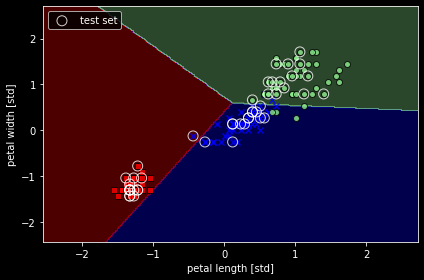

In [196]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X = X_combined_std,
                      y = y_combined,
                      classifier = ppn,
                      test_idx = range(105, 150))
plt.xlabel('petal length [std]')
plt.ylabel('petal width [std]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

## Logistic Regression

The perceptron never gonverge if the classes har not linearly seperable. The above plot shows a scenario where the classes _cannot_ be separated linearly, hence the Perceptron will _never_ converge. 

To solve this issue we will now investigate __logistic regression__. Note that logistic regression is a model for classification, and not regression. Just as the perceptron and Adaline, logistic regression is a _linear model_ for binary classification but it performs very well on linearly seperable classes.

To understand logistic regression, we need to introduce the concept of __ods__. Logistic regression is a probabilistic model for binary classification, where the ods of a particular event with the positive probability (e.g. class label y=1 etc) $p$ can be written as:

$$ \frac{p}{1 - p}$$

Further, we define the _logit_ function, or the _log-odds_ as:

$$ logit(p) = log \frac{p}{(1 - p)} ,$$

where $log$ is the _natural_ logarithm. Note that 

$$ D_{logit(p)} \in [0,\; 1],$$

while

$$ V_{logit(p)} \in \mathbb{R} $$.



This enables us to express a linear relationship between feature values and the log-odds:

$$ logit(p(y = 1|x)) = \vec{w}^{T} \vec{x} $$.

The probability that an example belongs to a perticular class is the inverse form of the logit function, which is known as the __logistic sigmoid function__, or often just the __sigmoid function__:

$$ \phi (z) = \frac{1}{1 + e^{-z}},$$

where $z$ is the net input.


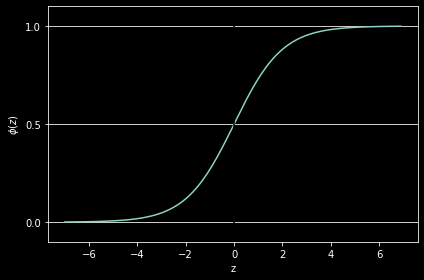

In [197]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1/(1 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()



We can now easily build the forward pass of a logistic regression model, by using a model similar to Adaline, but where the activation function is the sigmoid. Our threshold function can then map values > 0.5 as class 1 and values < 0.5 as class 0. This is natural, since the output from the sigmoid function is the probability that that particular example has class 1. 

## The Cost Function for Logistic Regression
We first define the _likelihood_, $L$, that we want to maximize when we build a logistic regression model, assuming that the individual example sin out dataset are independet of one another:

$$ L(\vec{w}) = P(\vec{y}|\vec{x};\vec{w}) = \Pi_{i=1}^{n} P({y}^{(i)} | x^{(i)}; \vec{w}) = \Pi_{i=1}^{n} \big( \phi(z^{(i)} ) \big)^{y^{(i)}} \big( 1 - \phi(z^{(i)} \big)^{1-y^{(i)}}$$

It is however easier to maximize the (natural) log of the likelihood function, the _log-likelihood_:

$$ l(\vec{w}) = log ( L(\vec{w}) = \Sigma_{i=1}^{n} \Big[ y^{(i)} log \big( \phi(z^{(i)}) \big) + \big(1-y^{(i)} \big) log \big(1 - \phi (z^{(i)}) \big) \Big]$$

Applying the log function also:

1) Reduces the risk for numerical underflow, which can happen in the likelihoods are small.
2) The products become additions which makes the derivative easier to obtain.

We could now _maximize_ the log-likelihood using, for example, gradient ascent. Alternatively, we can use gradient _descent_ as we have seen previously, if we change the sign of the function, yielding:

$$J(\vec{w}) = \Sigma_{i=1}^{n} \Big[- y^{(i)} log \big( \phi(z^{(i)}) \big) - \big(1-y^{(i)} \big) log \big(1 - \phi (z^{(i)}) \big) \Big]$$

Note that for a single example, the function will only have _one_ nonzero term depending on if $y=0$ and $y=1$.

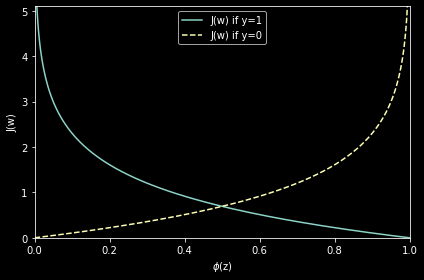

In [198]:
def cost_1(z):
    return -np.log(sigmoid(z))
def cost_0(z):
    return -np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Note that we penalize wrong predictions with an increasingly larger cost.

In [199]:
class LogisticRegressionGD(object):
    def __init__(self, eta = 0.05, n_iter = 100, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
        
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
        size=1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (-y.dot(np.log(output)) -
                   ((1 - y).dot(np.log(1 - output))))
            self.cost_.append(cost)
        return self
        
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        

Recall the the logistic regression model only will work for binary classification tasks. Once again, we consider the iris dataset:

<ipython-input-195-8a6e045c8e81>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
No handles with labels found to put in legend.


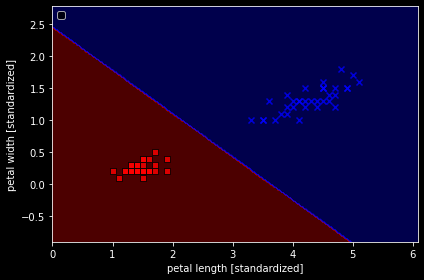

In [200]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta = 0.05,
                           n_iter = 1000,
                           random_state = 1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier = lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

<ipython-input-195-8a6e045c8e81>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


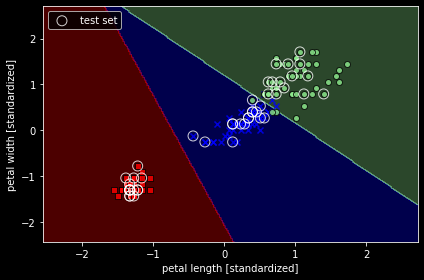

In [201]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100, random_state=1,
                       solver='lbfgs', multi_class='ovr')

lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier = lr,
                      test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [202]:
# lr.predict_proba(X_test_std[:3, :]).argmax(axis=1) is the same as:
lr.predict(X_test_std[:3,:])

print(X_test_std[0, :].reshape(1, -1))

[[0.89820289 1.44587881]]


## Regularization

If the model performs well on training data but does not generalize well to test data, we say that the model is __overfitted__ (or it has high variance). The opposite scenario is known as __underfitting__, meaning that the models does not perform well on the training data and therefore also fails at test data.

### The bias-variance tradeoff

1) High __variance__ is proportional to _overfitting_
2) High __bias__ is proportional to _underfitting_

In the context of machine learning models, __variance__ meassures the _consistency_ of the model prediction for classifying a particular if we retrain the model several times, using for example _different_ subsets of the training data. In this sense, we can say that a model has high variance if it's sensetive to randomness in training data. __Bias__ on the other hand measures how far off the predicitons are from the correct values in general, if we rebuild the model multiple times on the different subsets of the training data. 

__Regularization__ is one way of finding a good bias-variance tradeoff. It is useful for handling:

1)  High correlation among features (collinearity)
2) Noise from data
3) Preventing overfitting

The idea behind regularization is to introduce _additional information (bias)_ to penalize extreme parameter (weight) values. The most common way of achieving this is to implement __L2 regularization__:

$$ \frac{ \lambda }{2} || \vec{w} ||^{2} = \frac{ \lambda }{2} \Sigma_{j=1}^{m} w_{j}^{2}$$

Here, $\lambda$ is the __regularization parameter__. Note that, for regularization to work properly, it is important to normalize the different features. In practise, we simply add the regularization to term to the cost function, which shrinks the weights during training:

$$J(\vec{w}) = \Sigma_{i=1}^{n} \Big[- y^{(i)} log \big( \phi(z^{(i)}) \big) - \big(1-y^{(i)} \big) log \big(1 - \phi (z^{(i)}) \big) \Big] + \frac{ \lambda }{2} || \vec{w} ||^{2}$$

By increasing $\lambda$, we increase the regularization strength. The parameter $c$ that we used for the LogisticRegression class in scikit-learn, is exactly the inverse of $\lambda$. The convention $c$ comes from the domain of __support vector machines__ which will be the next topic of investigation in this notebook.



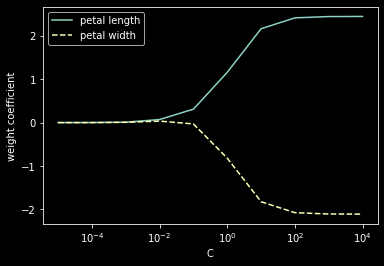

In [203]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state = 1,
                           solver = 'lbfgs', multi_class = 'ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
    
weights = np.array(weights)

plt.plot(params, weights[:, 0],
        label='petal length')
plt.plot(params, weights[:, 1], linestyle = '--',
        label = 'petal width')

plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()

The above example illustrates 10 fitted models with different inverse-regularization parameter, $c$. As we can see, the weight coefficients shrink if we decrease the parameter c, that is, if we increase the regularization strength. 

## Support Vector Machines \- Maximum Margin Classification

Support vector machines (SVM) can be considered an extension of the perceptron. Instead of minimizing misclassification errors, we will instead _maximize_ the _margin_. The margin is defined as the distance between the separating hyperplane (decision boundry) and the training examples that are closest to this hyperplane, which are the so-called __support vectors__. 

<ipython-input-195-8a6e045c8e81>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


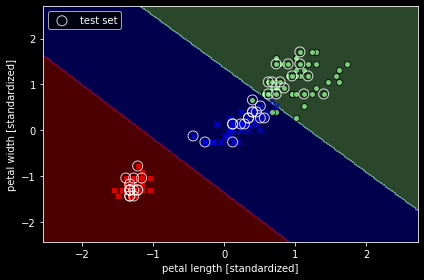

In [204]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                     y_combined,
                     classifier = svm,
                     test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

## Kernel Methods for Linearly Inseparable Data

This will be illustrated generating a dataset in the form of an XOR gate.

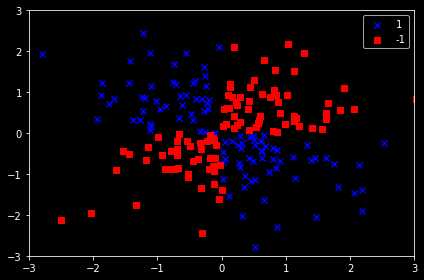

In [205]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c = 'b', marker = 'x',
            label = '1')

plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c = 'r', marker = 's',
            label = '-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Obviously, the data is not linearly separable. The basic idea behind __kernel methods__ is to create nonlinear combinations of the original features to project them onto a _higher-dimensional_ space via a mapping function $\phi$. If done correctly, the different classes will then be linearly seperable in this new space. One example is:

$$ \phi(x_1,\; x_2 ) = (z_1, \; z_2 , \; z_3 ) = (x_1 ,\; x_2 ,\; x_{1}^{2} + x_{2}^{2} ), $$

which would separate datapoints from a 2D plane into the direction perpendicular to the plane. 

One problem with this method, is that the construction of new features is computationally heavy if we have high-dimensional data. This is why __the kernel trick__ is popular. Let's define the __kernel function__:

$$\kappa \: \big(\vec{x}^{(i)} ,\; \vec{x}^{(j)} \big) = \phi \big( \vec{x}^{(i)}\big)^{T} \phi \big( \vec{x}^{(j)} \big) $$

One example of a commong kernel is the __radial basis funciton (RBF__ kernel, which often is called the __Gaussian kernel__:

$$\kappa \: \big(\vec{x}^{(i)} ,\; \vec{x}^{(j)} \big)  =
exp \Bigg( - \frac{|| \vec{x}^{(i)} - \vec{x}^{(j)}||^{2}}{2\sigma^{2}} \Bigg) := exp \Big( - \gamma \: || \vec{x}^{(i)} - \vec{x}^{(j)}||^{2} \Big),$$

Here, $\gamma$ is a free parameter to be optimized. We can think of the term "kernel" as a __similarity function__ between a pair of examples. The minus sign inverts the distance measure into a similarity score and the $exp$ funciton makes sure that the score $\in [0,\;1]$. 

Now, let's apply the RBF kernel and a SVM on the nonlinear data above:

<ipython-input-195-8a6e045c8e81>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
No handles with labels found to put in legend.


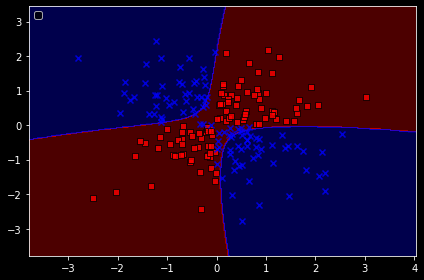

In [206]:
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.10, C = 10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier = svm)
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

Note that, $\gamma$ can be seen as a cut-off parameter for the Gaussian sphere. By increasing the value of $\gamma$ we increase the weight of each example, leading to _tighter_ and _bumpier_ decision boundry. We will now play around with the cut-off parameter on the iris dataset. 

<ipython-input-195-8a6e045c8e81>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


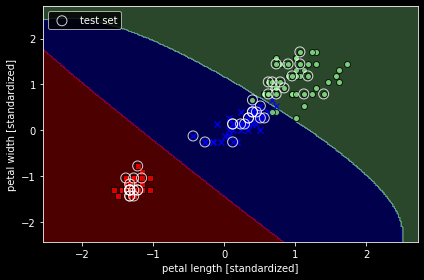

In [207]:


svm = SVC(kernel='rbf', random_state = 1, gamma = 0.2, C = 1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                     y_combined, classifier = svm,
                     test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

As we can see, since $\gamma$ was chosen relatively small, we get very smooth decision regions. By increasing the value to $100$ we get:  

<ipython-input-195-8a6e045c8e81>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


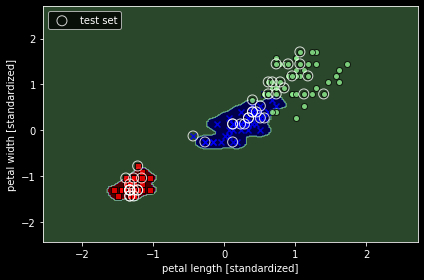

In [208]:
svm = SVC(kernel='rbf', random_state = 1, gamma = 100, C = 1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                     y_combined, classifier = svm,
                     test_idx = range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

The latter example would of course not generalize well to new unseen data. This means that $\gamma$ is super important with regards to avoiding overfitting and variance. 

## Decision Trees
We can think of decision tree models as a way of breaking down data by making decisions based on a series of questions. For the iris dataset, we could for example post the question "is the sepal width $\geq 2.8 $ [cm], and make a decision accordingly. 

With the __decision algorithm__ we start at the _tree root_ and split the data on the feature that results in the largest __information gain (IG)__. As we will see soon, information gain has a very precise mathematical meaning. The splitting procedure is an itterative process which go on until each child node (leaf) is __pure__, meaning that the training examples at each leaf belong to the same class.

In order to avoid overfitting, decision trees will oftan have to bee _pruned_, meaning that we only allow for a certain depth of the tree. 

## Maximizing information gain

By defining an objective function that we want to optimize, we are able to split the nodes at the most informative features. Our objective function will be the __information gain (IG)__, which is defined as:

$$IG(D_p ,\; f) = I(D_p) - \sum_{j=1}^{m} \frac{N_j}{N_p} I (D_j )  $$

* $f$ is the feature to perform the split
* $D_p$ and $D_j$ are the dataset of the parent and $j$:th child node
* $I$ is the _impurity measure_
* $N_p$ is the total number of samples at the parent node

This means that the information gain is the differenc between the impurity of the parent node and the sum of the child node impurities. In most libraries, each parent node is split into _two_ child nodes, $D_{left}$ and $D_{right}$:

$$
IG(D_p ,\; a) = I(D_p ) - \frac{N_{left}}{N_p} I(D_{left}) - \frac{N_{right}}{N_p} I(D_{right}).
$$

This fact reduces the combinatorial search space. There are __three__ impurity measures that are commonly used:

1. __Gini index ($I_g$) __ 
2. __Entropy ($I_h$) __
3. __Classification error ($I_e$) __

We will start by looking att the entropy impurity measure (for non-empty classes).

$$ I_H (t) = - \sum_{i=1}^{c} p(i|t)log_{2} \: p(i|t), \;\;\; p(i|t) \neq 0. $$


Here, $p(i|t)$ is the proportion of the samples that belongs to class $c$ for the node $t$. Note that $log_2 (1) = 0 $, meaning that the entropy is $0$ if all samples at a node belong to the same class. On the other hand, if the distribution is uniform, we have the maximum entropy of $1$. In this sense, we say that the entropy criterion attempts to maximize the mutual information in the tree.

Now, let's take a look att the _Gini index_. It can be interpreted as a criterion to __minimize__ the probability of misclassification:

$$
I_G (t) = \sum_{i=1}^{c} P (i|t) (-p(i|t)) = 1 - \sum_{i=1}^{c} p(i|t)^2
$$

The Gini index is also maximal if the classes are maximally mixed. However, in practice, bot the Gini index and entropy commonly yield similar results and it's often not worth spending time on evaluating trees using the different impurity measures. 

The last of the above-mentioned impurity measures is the __classification error__:

$$ I_E = 1 - max \{p(i|t) \}  $$

The classification criterion is mostly useful for _pruning_ and _not_ recommended for growing decision trees, since it's less sensitive to changes in the calss probabilities of the nodes. 


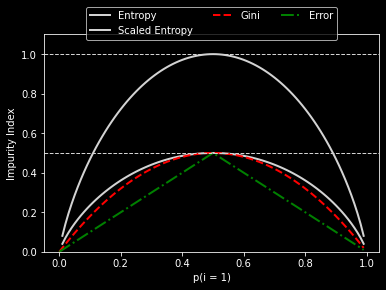

In [209]:

plt.style.use('dark_background')

def gini(p):
    return (p)*(1 - (p)) + (1 - p) * (1 - (1 - p))

def entropy(p):
    return - p * np.log2(p) - (1 - p )* np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

# Entropy
ent = [entropy(p) if p != 0 else None for p in x]
# Scaled entropy
sc_ent = [e * 0.5 if e else None for e in ent]
# Error
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                        ['Entropy', 'Scaled Entropy', 'Gini', 'Error'],
                        ['-', '-', '--', '-.'],
                        ['lightgray', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label = lab, linestyle = ls, lw = 2, color = c)

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.15), 
          ncol = 3, fancybox = True, shadow = False)

ax.axhline(y = 0.5, linewidth = 1, color = 'lightgray', linestyle='--')
ax.axhline(y = 1.0, linewidth = 1, color = 'lightgray', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i = 1)')
plt.ylabel('Impurity Index')
plt.show()

Above, we see how the different impurity criterion for the probability range $[0,\; 1]$.

### Building a decision tree using scikit-learn

We will now build a decision tree using scikit-learn. Decision trees can build decision boundrys using __rectangles__. However, this approach can easily lead to overfitting if the decision tree is too deep. The architecture we will use is a _decision tree_ with:

* Maximum depth of 3
* The entropy impurity index

<ipython-input-195-8a6e045c8e81>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


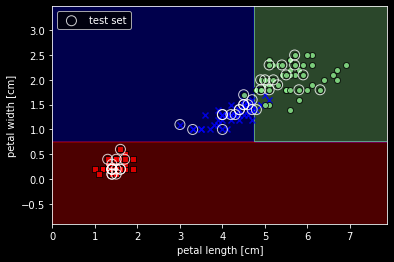

In [213]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = 3, random_state = 0)

tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined,   
                      classifier = tree, test_idx = range(105,150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc = 'upper left')
plt.show()

## Random forests